In [133]:
import numpy as np 
import pandas as pd
from datetime import datetime
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from matplotlib import pyplot as plt
%matplotlib inline

In [57]:
tuketim_df = pd.read_csv(r"C:\Users\cagatay.karabulut\Downloads\GercekZamanliTuketim-01012016-22112019.csv")

Train_df is before 01.01.2016 - 31.10.2019 
Test_df is 01.11.2019 - 07.11.2019

In [68]:
tuketim_df.set_index(["Tarih","Saat"], inplace = True)
tuketim_df["Tuketim Miktari (MWh)"] = [float(i.replace(".","").replace(",",".")) for i in tuketim_df["Tuketim Miktari (MWh)"]]

In [71]:
train_df = tuketim_df[:33576]
test_df = tuketim_df[33576:33744]

In [69]:
tuketim_df.head()

Tuketim Miktari (MWh)
Tarih      Saat                        
01.01.2016 00:00               26277.24
           01:00               24991.82
           02:00               23532.61
           03:00               22464.78
           04:00               22002.91

# Part A

In [73]:
prediction_df = pd.DataFrame()
prediction_df["Consumption"] = test_df["Tuketim Miktari (MWh)"]
prediction_df["Lag_168"]     = list(train_df["Tuketim Miktari (MWh)"][-168:])
prediction_df["Lag_48"]      = list(train_df["Tuketim Miktari (MWh)"][-48:]) +list(test_df["Tuketim Miktari (MWh)"][:120])

In [76]:
sum_percentage_error_168 = []
sum_percentage_error_48  = []
for index, row in prediction_df.iterrows():
    sum_percentage_error_168.append(abs((row["Consumption"] - row["Lag_168"]) / row["Consumption"]))
    sum_percentage_error_48.append(abs((row["Consumption"] - row["Lag_48"]) / row["Consumption"]))
mape_168 = sum(sum_percentage_error_168) / 168
mape_48 = sum(sum_percentage_error_48) / 168
print("MAPE value for Lag_168 is {}".format(mape_168))
print("MAPE value for Lag_48 is {}".format(mape_48))

MAPE value for Lag_168 is 0.04916488203126904
MAPE value for Lag_48 is 0.08017726468896307


# Part B

In [80]:
prediction_df_2 = pd.DataFrame()
prediction_df_2["Consumption"] = train_df["Tuketim Miktari (MWh)"][168:].append(test_df["Tuketim Miktari (MWh)"]) 
prediction_df_2["Lag_168"]     = list(train_df["Tuketim Miktari (MWh)"])
prediction_df_2["Lag_48"]      = list(train_df["Tuketim Miktari (MWh)"][120:]) +list(test_df["Tuketim Miktari (MWh)"][:120])

In [91]:
lr = LinearRegression()
lr = lr.fit(X = prediction_df_2[["Lag_168","Lag_48"]][:-168], y = prediction_df_2["Consumption"][:-168])
prediction = lr.predict(X = prediction_df_2[["Lag_168","Lag_48"]][-168:])
test_2 = prediction_df_2["Consumption"][-168:]

In [93]:
sum_percentage_error = 0
for i in range(168):
    sum_percentage_error += abs((prediction[i] - test_2[i]) / test_2[i])
mape = sum_percentage_error / 168
print("MAPE value for linear regression model with lag 168 and 48 is {}".format(mape))

MAPE value for linear regression model with lag 168 and 48 is 0.0519227076011569


# Part C

In [112]:
mape_values = []
for i in range(24):
    lr = LinearRegression()
    lr_hourly = lr.fit(X = prediction_df_2[["Lag_168","Lag_48"]].iloc[i:-168:24], 
                                   y = prediction_df_2["Consumption"].iloc[i:-168:24])
    prediction_hourly = lr.predict(X = prediction_df_2[["Lag_168","Lag_48"]].iloc[-168+i::24])
    test_hourly = prediction_df_2["Consumption"].iloc[-168+i::24]
    sum_percentage_error = 0
    for j in range(7):
        sum_percentage_error += abs((prediction_hourly[j] - test_hourly[j]) / test_hourly[j])
    mape = sum_percentage_error / 7
    mape_values.append(mape)
    print("MAPE value for linear regression model with lag 168 and 48 for hour {}.00 is {}".format(i,mape))

MAPE value for linear regression model with lag 168 and 48 for hour 0.00 is 0.03659787463398403
MAPE value for linear regression model with lag 168 and 48 for hour 1.00 is 0.03774788227154174
MAPE value for linear regression model with lag 168 and 48 for hour 2.00 is 0.04084911863638306
MAPE value for linear regression model with lag 168 and 48 for hour 3.00 is 0.04116815579078393
MAPE value for linear regression model with lag 168 and 48 for hour 4.00 is 0.038119395966837076
MAPE value for linear regression model with lag 168 and 48 for hour 5.00 is 0.039860450398356014
MAPE value for linear regression model with lag 168 and 48 for hour 6.00 is 0.04975175345761416
MAPE value for linear regression model with lag 168 and 48 for hour 7.00 is 0.060917921078519864
MAPE value for linear regression model with lag 168 and 48 for hour 8.00 is 0.06763516731737793
MAPE value for linear regression model with lag 168 and 48 for hour 9.00 is 0.06395710732578268
MAPE value for linear regression mode

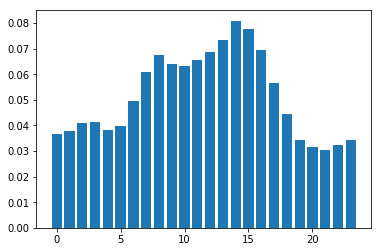

In [116]:
p = plt.bar(np.arange(24), mape_values)
plt.show()

# Part D

In [127]:
list_to_df = []
for date, date_df in prediction_df_2.groupby("Tarih"):
    feature_list = []
    for index, row in date_df.iterrows():
        feature_list.append(row["Lag_168"])
    for index, row in date_df.iterrows():
        feature_list.append(row["Lag_48"])
    for index, row in date_df.iterrows():
        feature_list.append(row["Consumption"])
    list_to_df.append(feature_list)

In [129]:
wide_prediction_df = pd.DataFrame(list_to_df, columns = ['Lag_7_Day_Hour_{}'.format(i) for i in range(24)] + 
                                                        ['Lag_2_Day_Hour_{}'.format(i) for i in range(24)] +
                                                        ['Consumption_Hour_{}'.format(i) for i in range(24)] )

In [ ]:
mape_values_lasso = []
lasso_coefs = []
for i in range(24):
    lasso_cv_model = LassoCV(cv=10, max_iter = 5000)
    lasso_cv_model = lasso_cv_model.fit(X = wide_prediction_df.loc[:,"Lag_7_Day_Hour_0":"Lag_2_Day_Hour_23"], 
                                   y = wide_prediction_df.loc[:,"Consumption_Hour_{}".format(i)])
    #Alpha is calculated by the LassoCV function
    lasso_model = Lasso(alpha=lasso_cv_model.alpha_)
    lasso_model = lasso_model.fit(X = wide_prediction_df.loc[:1392,"Lag_7_Day_Hour_0":"Lag_2_Day_Hour_23"], 
                                  y = wide_prediction_df.loc[:1392,"Consumption_Hour_{}".format(i)])
    predictions = lasso_model.predict(X = wide_prediction_df.loc[1392:,"Lag_7_Day_Hour_0":"Lag_2_Day_Hour_23"])
    actual = list(wide_prediction_df.loc[1392:,"Consumption_Hour_{}".format(i)])
    sum_percentage_error = 0
    for j in range(7):
        sum_percentage_error += abs((predictions[j] - actual[j]) / actual[j])
    mape = sum_percentage_error / 7
    mape_values_lasso.append(mape)
    lasso_coefs.append(lasso_model.coef_)

In [173]:
for i in range(24):
    print("MAPE value for Lasso model for hour {}.00 is {}".format(i,mape_values_lasso[i]))

MAPE value for Lasso model for hour 0.00 is 0.027842005729091363
MAPE value for Lasso model for hour 1.00 is 0.031439828589648534
MAPE value for Lasso model for hour 2.00 is 0.03324433063307667
MAPE value for Lasso model for hour 3.00 is 0.03114321540543765
MAPE value for Lasso model for hour 4.00 is 0.03473149429331673
MAPE value for Lasso model for hour 5.00 is 0.03579191196308364
MAPE value for Lasso model for hour 6.00 is 0.04173220668585941
MAPE value for Lasso model for hour 7.00 is 0.04763229598211084
MAPE value for Lasso model for hour 8.00 is 0.05701293546277072
MAPE value for Lasso model for hour 9.00 is 0.058412969592203816
MAPE value for Lasso model for hour 10.00 is 0.05608811735885071
MAPE value for Lasso model for hour 11.00 is 0.05476089432840118
MAPE value for Lasso model for hour 12.00 is 0.05268468186666435
MAPE value for Lasso model for hour 13.00 is 0.056613164243809536
MAPE value for Lasso model for hour 14.00 is 0.06440747690787632
MAPE value for Lasso model for 

In [177]:
coef_df = pd.DataFrame(lasso_coefs, columns = ['7_Day_{}_Hour'.format(i) for i in range(24)] + 
                                              ['2_Day_{}_Hour'.format(i) for i in range(24)])

In [197]:
print(wide_prediction_df.columns[np.argsort([abs(i) for i in lasso_coefs])][0])

['Lag_7_Day_Hour_23' 'Lag_2_Day_Hour_6' 'Lag_2_Day_Hour_5'
 'Lag_2_Day_Hour_3' 'Lag_2_Day_Hour_2' 'Lag_2_Day_Hour_15'
 'Lag_7_Day_Hour_21' 'Lag_2_Day_Hour_17' 'Lag_7_Day_Hour_17'
 'Lag_2_Day_Hour_12' 'Lag_7_Day_Hour_15' 'Lag_2_Day_Hour_19'
 'Lag_7_Day_Hour_13' 'Lag_7_Day_Hour_16' 'Lag_7_Day_Hour_11'
 'Lag_7_Day_Hour_1' 'Lag_7_Day_Hour_2' 'Lag_7_Day_Hour_3'
 'Lag_7_Day_Hour_4' 'Lag_7_Day_Hour_5' 'Lag_7_Day_Hour_12'
 'Lag_2_Day_Hour_8' 'Lag_7_Day_Hour_8' 'Lag_7_Day_Hour_9'
 'Lag_7_Day_Hour_10' 'Lag_2_Day_Hour_21' 'Lag_2_Day_Hour_18'
 'Lag_2_Day_Hour_20' 'Lag_2_Day_Hour_4' 'Lag_2_Day_Hour_16'
 'Lag_7_Day_Hour_18' 'Lag_2_Day_Hour_14' 'Lag_7_Day_Hour_22'
 'Lag_7_Day_Hour_0' 'Lag_2_Day_Hour_1' 'Lag_2_Day_Hour_11'
 'Lag_7_Day_Hour_14' 'Lag_7_Day_Hour_7' 'Lag_7_Day_Hour_6'
 'Lag_2_Day_Hour_0' 'Lag_7_Day_Hour_20' 'Lag_2_Day_Hour_10'
 'Lag_7_Day_Hour_19' 'Lag_2_Day_Hour_22' 'Lag_2_Day_Hour_13'
 'Lag_2_Day_Hour_7' 'Lag_2_Day_Hour_9' 'Lag_2_Day_Hour_23']


In [228]:
for i in range(24):
    sorted_index = np.argsort((-np.array([abs(i) for i in coef_df.iloc[i]])))
    print('Important_coefficients for Hour {}:{}'.format(i, coef_df.columns[sorted_index[0]]))
    print('Important_coefficients for Hour {}:{}'.format(i, coef_df.columns[sorted_index[1]]))
    print('Important_coefficients for Hour {}:{}'.format(i, coef_df.columns[sorted_index[2]]))

Important_coefficients for Hour 0:2_Day_23_Hour
Important_coefficients for Hour 0:2_Day_9_Hour
Important_coefficients for Hour 0:2_Day_7_Hour
Important_coefficients for Hour 1:2_Day_23_Hour
Important_coefficients for Hour 1:2_Day_9_Hour
Important_coefficients for Hour 1:2_Day_0_Hour
Important_coefficients for Hour 2:2_Day_23_Hour
Important_coefficients for Hour 2:2_Day_0_Hour
Important_coefficients for Hour 2:2_Day_9_Hour
Important_coefficients for Hour 3:2_Day_23_Hour
Important_coefficients for Hour 3:2_Day_0_Hour
Important_coefficients for Hour 3:2_Day_4_Hour
Important_coefficients for Hour 4:2_Day_23_Hour
Important_coefficients for Hour 4:2_Day_4_Hour
Important_coefficients for Hour 4:2_Day_0_Hour
Important_coefficients for Hour 5:2_Day_23_Hour
Important_coefficients for Hour 5:2_Day_5_Hour
Important_coefficients for Hour 5:2_Day_13_Hour
Important_coefficients for Hour 6:2_Day_23_Hour
Important_coefficients for Hour 6:2_Day_13_Hour
Important_coefficients for Hour 6:2_Day_9_Hour
Impo

The coefficients shown above imply that feature importance in this context may be because of weekday-weekend difference and 
hourly differences between these two. Generally speaking; Lag 2 Hour 23 and Hour 13 is generally important in predictions.

# Part F

{'whiskers': [<matplotlib.lines.Line2D at 0x1d21455df60>,
 'caps': [<matplotlib.lines.Line2D at 0x1d217a41630>,
 'boxes': [<matplotlib.lines.Line2D at 0x1d21455deb8>,
 'medians': [<matplotlib.lines.Line2D at 0x1d217a41e48>,
 'fliers': [<matplotlib.lines.Line2D at 0x1d2145ef748>,
 'means': []}

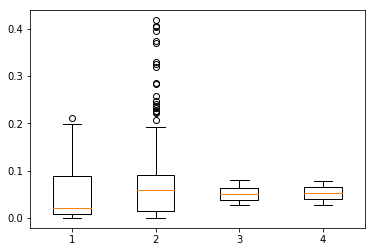

In [247]:
mapes = [sum_percentage_error_168, sum_percentage_error_48, mape_values, mape_values_lasso]
plt.boxplot(mapes)

As we can see in the boxplot (1:Naive 168, 2:Naive 48, 3:Linear Regression, 4:Lasso Regression) linear regression and lasso regression gives stable and fairly low errors whereas lag 48 fails probably because of the weekday-weekend problem we mentioned.
Naive approach has better mean but is not stable due to probably seasonality between weeks. 